# Can we write a multibillion-stream song? A datadriven exploration 

So as usual every year in december I ended up getting an e-mail from Spotify and my instagram was flooded with posts of "Spotify wrapped 2024, this was your year in music!". As I, and a lot of other people, took to their phones or (whatever machine you use) to check out what's been their most listened too song of 2024, it got me thinking. I've been listening to a lot of music over the years, being a complete music fan. And I've had the feeling that maybe complexity of songwriting is changing (or has been chaning quite a bit) over the last 40 years. Therefore I decided to give it a go at analyzing the 100 most streamed songs ever on Spotify to see if we can find some insights into wether or not complexity has changed and what it actually takes to write a hit song these days. We'll only be working with the musical chords in this exploration since incorporating both melody, lyrics, instruments and whatever other metrics quickly became overwhelming for the scope of this project. 

The dataset's we'll be using is a mix of a scrape from wikipedias top 100 most streamed songs and then a kinda handmade dataset of chords from ultimate-guitar.com, where people put down chords and tabs for others who wish to learn their song. 

Let's begin by scraping the list we need from wikipedia. Below is a simple scraper to grab the table from https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records and then save that as a csv file. 

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def scrape_spotify_records(url):
    # Send a GET request to the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # find and extract data from the first wikitable
    tables = soup.find_all("table", {"class": "wikitable"})
    if not tables:
        raise ValueError("No tables found on the page!")
    table = tables[0]
    
    # extract rows and columns
    records = [
        [col.text.strip() for col in row.find_all(["th", "td"])]
        for row in table.find_all("tr")
    ]
    
    # convert to df
    return pd.DataFrame(records[1:], columns=records[0])

# url of wikipage 
url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"
spotify_records = scrape_spotify_records(url)

# saving a csv as backup just in case
spotify_records.to_csv("spotify_streaming_records.csv", index=False)
print("Spotify streaming records saved to 'spotify_streaming_records.csv'.")

spotify_records.head(100)

Spotify streaming records saved to 'spotify_streaming_records.csv'.


,Rank,Song,Artist(s),Streams(billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.648,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.175,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.750,8 November 2018,[4]
3,4,"""As It Was""",Harry Styles,3.710,1 April 2022,[5]
4,5,"""Starboy""",The Weeknd and Daft Punk,3.675,21 September 2016,[6]
...,...,...,...,...,...,...
95,96,"""The Scientist""",Coldplay,2.150,26 May 2002,[99]
96,97,"""Seven""",Jung Kook and Latto,2.144,14 July 2023,[100]
97,98,"""Till I Collapse""",Eminem and Nate Dogg,2.129,26 May 2002,[101]
98,99,"""Dakiti""",Bad Bunny and Jhayco,2.115,30 October 2020,[102]


Great! Now that we have a list of the most streamed songs ever, let's begin the process of merging it with the dataset that we have collected. Since ultimate-guitar has no API to get the song chords associated with each song I ended up speninding hours trying to build a working selenium script to grab the chords. Sometimes you have to admit defeat and simply realize that since there are only a 100 entries in this dataset (I know, it's not huge) the best solution would be to just manually grab them from the website. In case you're curious, the chords in the dataset were picked from https://tabs.ultimate-guitar.com/tab/the-weeknd/blinding-lights-chords-2908700 for example. (Yes there is a link column included, I tried some other shenanigans but for ethical reasons, let's leave it at that).

Let's begin loading and cleaning the "Chords_Dataset.csv"..  

In [3]:
# Load the chord dataset and begin cleaning and mergin
"""
Function that takes in the dataset, 

"""
def clean_and_load_chords_dataset(filepath):
    # load dataset
    chords_dataset = pd.read_csv(filepath, sep=';', on_bad_lines='skip')

    # Clean and normalize text columns
    for col in ['Song', 'Artist(s)']:
        chords_dataset[col] = chords_dataset[col].str.replace('"', '').str.strip().str.lower()

    # Clean up Chords column
    chords_dataset['Chords'] = chords_dataset['Chords'].str.replace(r'[\[\]\"]', '', regex=True)
    chords_dataset['Chords'] = chords_dataset['Chords'].str.replace("'", "", regex=True).str.strip()
    return chords_dataset

chords_dataset = clean_and_load_chords_dataset("Chords_Dataset.csv")

# Clean and Prepare Spotify Records for Merging
for col in ['Song', 'Artist(s)']:
    spotify_records[col] = spotify_records[col].str.replace('"', '').str.strip().str.lower()

# Step 4: Merge Datasets
merged_dataset = pd.merge(
    spotify_records,
    chords_dataset,
    on=['Song', 'Artist(s)'],
    how='inner'
)

# Remove Rows with Missing Chords and Rename Columns
cleaned_dataset = merged_dataset[merged_dataset['Chords'].notna() & (merged_dataset['Chords'] != '')].copy()

cleaned_dataset.rename(
    columns={
        'Song': 'Song_Title',
        'Artist(s)': 'Artist',
        'Streams(billions)': 'Total_Streams',
        'Chords': 'Chord_Progressions',
    },
    inplace=True
)

# Drop unwanted columns
cleaned_dataset.drop(columns=['Chords 2', 'Ref.', 'Link'], inplace=True)


# Save the cleaned dataset to a new CSV file
cleaned_dataset.to_csv("Cleaned_Dataset_Chords.csv", index=False)
print("Cleaned dataset saved to 'Cleaned_Dataset_Chords.csv'.")

cleaned_dataset.head(10)

Cleaned dataset saved to 'Cleaned_Dataset_Chords.csv'.


,Rank,Song_Title,Artist,Total_Streams,Release date,Chord_Progressions
0,1,blinding lights,the weeknd,4.648,29 November 2019,"C, Dm, Am"
1,2,shape of you,ed sheeran,4.175,6 January 2017,"Dm, G#m, B, C#"
2,3,someone you loved,lewis capaldi,3.750,8 November 2018,"D, A, Bm, G, Em, Em7, Bm7"
3,4,as it was,harry styles,3.710,1 April 2022,"C#m, F#, B, E"
4,5,starboy,the weeknd and daft punk,3.675,21 September 2016,"A5, Am, G/A, F/A, G6/A, Fmaj7, G, F, Cmaj7, G6..."
5,6,sunflower,post malone and swae lee,3.664,18 October 2018,"D, G, Em"
6,7,one dance,drake featuring wizkid and kyla,3.484,5 April 2016,"C#, A#m, D#m"
7,8,sweater weather,the neighbourhood,3.483,3 December 2012,"F#, D#m, A#m, C#, G#"
8,9,stay,the kid laroi and justin bieber,3.419,9 July 2021,"G, A, Bm, F#m"
9,10,believer,imagine dragons,3.280,1 February 2017,"Bm, G, F#, F#/A#, A, F#7, F#7/A#"


Okay! Now that we have a clean data set we can begin our analysis of chords! 
It might not be the biggest dataset but i'm sure we can pull some interesting
insights from this.

So now we can finally start figuring out how we're gonna write the next big hit song! First of all: What is the optimal number of chords for a multi-billion streaming song then? 

Seeing as we have a pretty wide range in number of chords per song, perhaps we can figure out statistically how many chords we actually need to write a multi-billion streaming song in 2025. To do this we can setup a linear regression model and see if we can draw some conclusion as to what the optimal chord count would be!

We can set it up so that we use the number of chords, "Chord_Count" as the X variable and the "Total_Streams" as the y, then we'd have to add a constant 

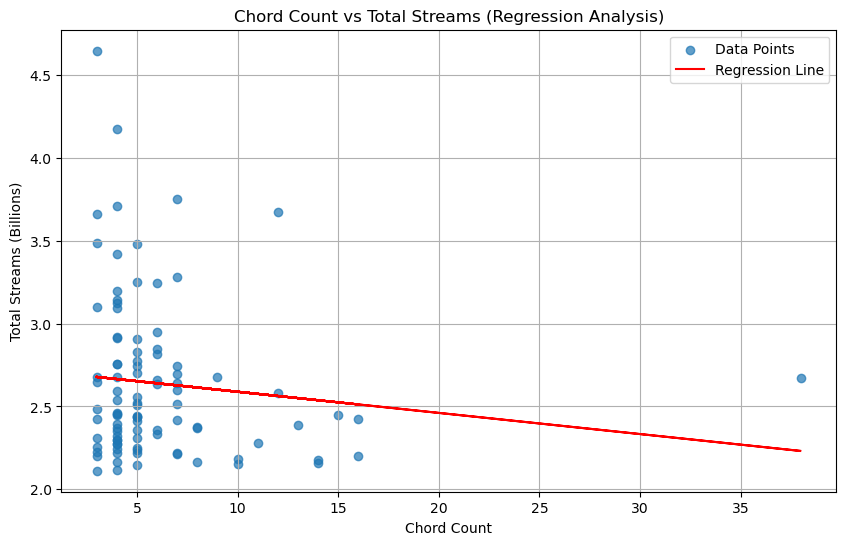

The optimal chord count for maximizing streams is: 3
Slope: -0.012780570850224698, Intercept: 2.716699948844603


In [4]:
# Add Chord_Count column
cleaned_dataset['Chord_Count'] = cleaned_dataset['Chord_Progressions'].apply(lambda x: len(x.split(',')))

# Ensure Total_Streams is numeric
cleaned_dataset['Total_Streams'] = cleaned_dataset['Total_Streams'].apply(
    lambda x: ''.join(c for c in str(x) if c.isdigit() or c == '.')
)
cleaned_dataset['Total_Streams'] = pd.to_numeric(cleaned_dataset['Total_Streams'], errors='coerce')
cleaned_dataset.dropna(subset=['Total_Streams'], inplace=True)

# Prepare the data
X = cleaned_dataset['Chord_Count']
y = cleaned_dataset['Total_Streams']

# Fit a linear regression model manually
X_mean = np.mean(X)
y_mean = np.mean(y)

# Slope (m)
numerator = np.sum((X - X_mean) * (y - y_mean))
denominator = np.sum((X - X_mean) ** 2)
slope = numerator / denominator

# Intercept (c)
intercept = y_mean - slope * X_mean

# Function to predict y values
def predict(x):
    return slope * x + intercept

# Predicted y values
y_pred = predict(X)

# Visualization of the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, label='Data Points')
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.title('Chord Count vs Total Streams (Regression Analysis)')
plt.xlabel('Chord Count')
plt.ylabel('Total Streams (Billions)')
plt.legend()
plt.grid(True)
plt.show()

# Predict Total Streams for a range of chord counts
chord_range = np.arange(int(X.min()), int(X.max()) + 1)
predicted_streams = predict(chord_range)

# Identify the chord count with the maximum predicted streams
optimal_chord_count = chord_range[np.argmax(predicted_streams)]
print(f"The optimal chord count for maximizing streams is: {optimal_chord_count}")

# Print slope and intercept for reference
print(f"Slope: {slope}, Intercept: {intercept}")

# Save cleaned dataset and predictions
cleaned_dataset.to_csv("Cleaned_Dataset_Chords_With_Count.csv", index=False)
predictions = pd.DataFrame({'Chord_Count': chord_range, 'Predicted_Streams': predicted_streams})
predictions.to_csv("Predicted_Streams.csv", index=False)


Okay, so we can see that as the number of chords in a song increase, the streaming actually seem to decrease, clearly Queen's - Bohemian Rhapsody is still the outlier here and our dataset is still fairly small but simply put: We want to keep it simple! 3 Chords is appearantly all we need, but then the follow up question becomes, what chords?

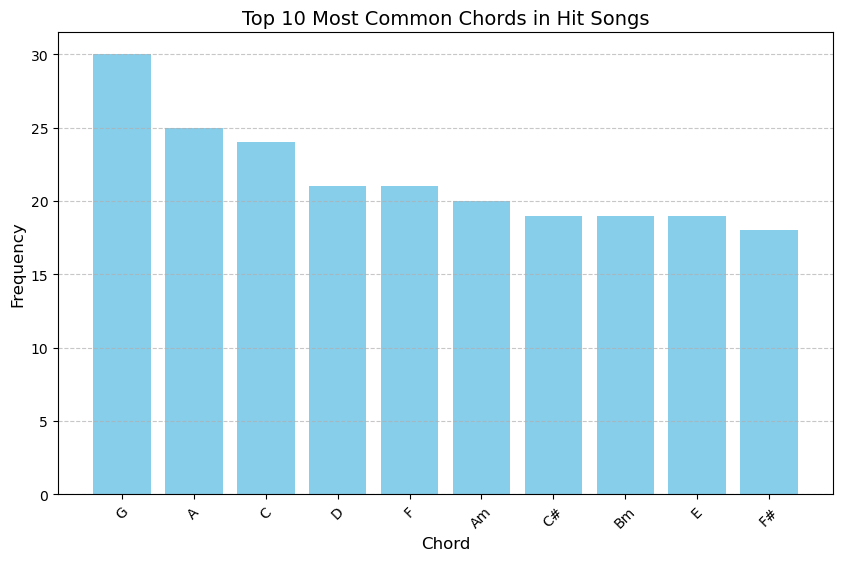

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract all chords from the dataset
all_chords = [chord.strip() for progression in cleaned_dataset['Chord_Progressions'] for chord in progression.split(',')]

# Count the frequencies of each chord
chord_counts = Counter(all_chords)

# Convert to a DataFrame for easier visualization
chord_counts_df = pd.DataFrame(chord_counts.items(), columns=['Chord', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Bar chart of the most common chords
plt.figure(figsize=(10, 6))
plt.bar(chord_counts_df['Chord'][:10], chord_counts_df['Frequency'][:10], color='skyblue')
plt.title('Top 10 Most Common Chords in Hit Songs', fontsize=14)
plt.xlabel('Chord', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Aha! So using G, A, C seem like the obvious choice, but wait a minute... The Weeknd - Blinding lights is clearly the most streamed song in the world and to me it doesn't sound all that happy? So how do we tackle this? An idea is to assign a score to each chord. Let's begin by printing all the unique chords and then figure out how to assign a value to them. 

We can setup a dictionary: it's gonna take a little bit of work but we'll get there. First let's find the unique chords, then we setup a dictionary. 

In [6]:
# Function to clean chord names
def clean_chord_names(chord_progression):
    chords = chord_progression.split(',')
    cleaned_chords = [chord.strip().replace('’', '').replace("'", "") for chord in chords]
    return ','.join(cleaned_chords)

# Apply the cleaning function to the Chord_Progressions column
cleaned_dataset['Chord_Progressions'] = cleaned_dataset['Chord_Progressions'].apply(clean_chord_names)

# Extract all unique cleaned chords for verification
all_chords = set()
for progression in cleaned_dataset['Chord_Progressions']:
    chords = progression.split(',')
    all_chords.update(chord.strip() for chord in chords)

# Display the unique cleaned chords
print("Cleaned Unique Chords in Dataset:", all_chords)

Cleaned Unique Chords in Dataset: {'C#m/E', 'F5', 'A#m', 'D#m7', 'D#/G', 'E7', 'F#m', 'Amaj7', 'Bm9', 'Em7', 'G7', 'Fm7', 'D#sus4', 'B/F#', 'C5', 'F6/9', 'Adim', 'Dadd9', 'F', 'F#9', 'Bbmaj7', 'Cmaj7', 'Cadd9', 'F#7#9', 'Bm', 'Gsus4', 'Bm/D', 'B5', 'Am', 'G#7/D#', 'G#dim', 'Dm7', 'Em/G', 'C/B', 'G#m7', 'F7', 'D#', 'G#5', 'Eadd9', 'Gmaj7', 'A#', 'Ab6/Bb', 'Ab', 'D/E', 'B/C#', 'A#5', 'A/C#', 'E', 'E5', 'G#m', 'F#madd9', 'D#5', 'Cmaj7/E', 'F#6', 'Em/B', 'Fm', 'F#m7', 'Cm7', 'D7', 'Cm6/Eb', 'A#m7', 'G6', 'Dm7/C', 'Emaj7', 'C#5', 'Eb6', 'C#m7', 'D#m', 'F#7', 'G5', 'D#m/A#', 'D#/G#', 'C#', 'Edim7', 'Fmaj7', 'C/G', 'Eb', 'C#m', 'Amaj7/C#', 'F#dim', 'Bdim', 'Bmadd9', 'G/A', 'Cm9', 'G#m/B', 'G/D', 'D#/A#', 'G#', 'Dm', 'F#/A#', 'C', 'C7', 'Am7', 'Bb', 'A/B', 'Bm7', 'E/G#', 'Cm', 'Bsus4', 'Gmaj9', 'B7sus4', 'G#sus2', 'C#/F', 'G/B', 'Dmaj7', 'C#dim', 'D/F#', 'F#7/A#', 'G6/A', 'Gbm', 'D5', 'D', 'A', 'Edim', 'A7', 'Cmaj7/B', 'Cm6/D', 'Gm', 'G#dim/B', 'D#m/B', 'D#m/G#', 'Cm/Eb', 'A5', 'C#7', 'B7', 'G

In [7]:
# Initial mood_scores dictionary
mood_scores = {
    # Major chords
    'C': 1.0, 'D': 1.0, 'E': 1.0, 'F': 1.0, 'G': 1.0, 'A': 1.0, 'B': 1.0,
    # Minor chords
    'Cm': -1.0, 'Dm': -1.0, 'Em': -1.0, 'Fm': -1.0, 'Gm': -1.0, 'Am': -1.0, 'Bm': -1.0,
    # Diminished chords
    'Cdim': -0.25, 'Ddim': -0.25, 'Edim': -0.25, 'Fdim': -0.25, 'Gdim': -0.25, 'Adim': -0.25, 'Bdim': -0.25,
    # Augmented chords
    'Caug': 0.25, 'Daug': 0.25, 'Eaug': 0.25, 'Faug': 0.25, 'Gaug': 0.25, 'Aaug': 0.25, 'Baug': 0.25,
    # Major 7th chords
    'Cmaj7': 0.5, 'Dmaj7': 0.5, 'Emaj7': 0.5, 'Fmaj7': 0.5, 'Gmaj7': 0.5, 'Amaj7': 0.5, 'Bmaj7': 0.5,
    # Minor 7th chords
    'Cm7': -0.5, 'Dm7': -0.5, 'Em7': -0.5, 'Fm7': -0.5, 'Gm7': -0.5, 'Am7': -0.5, 'Bm7': -0.5,
    # Dominant 7th chords
    'C7': 0.2, 'D7': 0.2, 'E7': 0.2, 'F7': 0.2, 'G7': 0.2, 'A7': 0.2, 'B7': 0.2,
    # Suspended chords
    'Csus2': 0.0, 'Dsus2': 0.0, 'Esus2': 0.0, 'Fsus2': 0.0, 'Gsus2': 0.0, 'Asus2': 0.0, 'Bsus2': 0.0,
    'Csus4': 0.0, 'Dsus4': 0.0, 'Esus4': 0.0, 'Fsus4': 0.0, 'Gsus4': 0.0, 'Asus4': 0.0, 'Bsus4': 0.0,
}

# Identify missing chords
missing_chords = all_chords - set(mood_scores.keys())

# Assign scores to missing chords
for chord in missing_chords:
    if "m" in chord and not chord.startswith("C#m"):  # Likely a minor chord
        mood_scores[chord] = -1.0
    elif "dim" in chord:  # Diminished
        mood_scores[chord] = -0.25
    elif "aug" in chord:  # Augmented
        mood_scores[chord] = 0.25
    elif "7" in chord:  # Extended chords
        if "maj7" in chord:
            mood_scores[chord] = 0.5
        elif "m7" in chord:
            mood_scores[chord] = -0.5
        else:  # Dominant 7th
            mood_scores[chord] = 0.2
    elif "sus" in chord:  # Suspended chords
        mood_scores[chord] = 0.0
    elif "/" in chord:  # Slash chords
        base_chord = chord.split("/")[0]
        mood_scores[chord] = mood_scores.get(base_chord, 0)
    else:  # Default to major
        mood_scores[chord] = 1.0
        

        
missing_chords = all_chords - set(mood_scores.keys())
if missing_chords:
    print("Still Missing Chords:", missing_chords)
else:
    print("All chords are now covered in mood_scores!")

    
# Check the score of specific chords
print("Mood score for D#7:", mood_scores.get("D#7"))

All chords are now covered in mood_scores!
Mood score for D#7: 0.2


In [8]:
# Function to calculate Mood Balance for a song
def calculate_mood_balance(chord_progression):
    chords = chord_progression.split(',')
    scores = [mood_scores.get(chord.strip(), 0) for chord in chords]
    return sum(scores) / len(scores) if scores else 0

# Apply the function to your dataset
cleaned_dataset['Mood_Balance'] = cleaned_dataset['Chord_Progressions'].apply(calculate_mood_balance)

# Preview the updated dataset
print(cleaned_dataset[['Artist','Song_Title', 'Mood_Balance']].head())

                     Artist         Song_Title  Mood_Balance
0                the weeknd    blinding lights     -0.333333
1                ed sheeran       shape of you      0.000000
2             lewis capaldi  someone you loved      0.000000
3              harry styles          as it was      1.000000
4  the weeknd and daft punk            starboy      0.750000


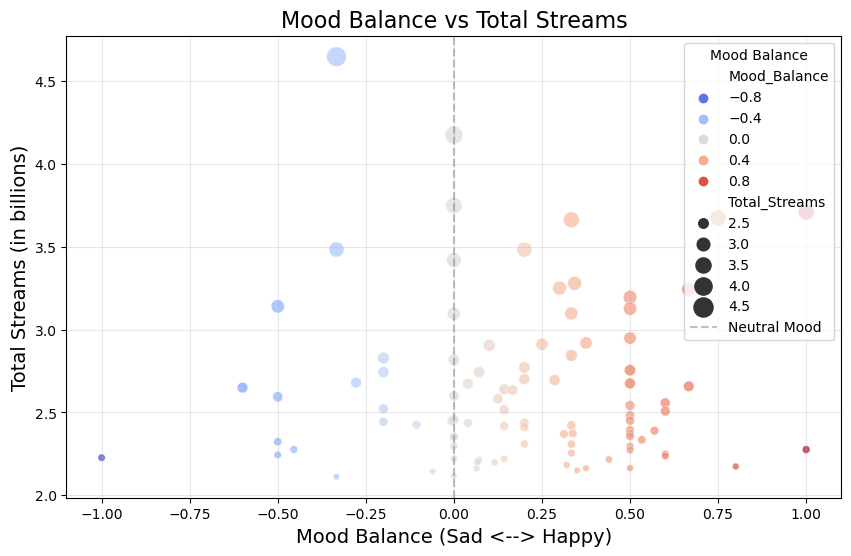

In [9]:
# Scatter plot of Mood Balance vs Total Streams
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Mood_Balance', 
    y='Total_Streams', 
    data=cleaned_dataset, 
    hue='Mood_Balance', 
    palette='coolwarm', 
    size='Total_Streams', 
    sizes=(20, 200), 
    alpha=0.7
)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Neutral Mood')
plt.title('Mood Balance vs Total Streams', fontsize=16)
plt.xlabel('Mood Balance (Sad <--> Happy)', fontsize=14)
plt.ylabel('Total Streams (in billions)', fontsize=14)
plt.legend(title='Mood Balance', fontsize=10, loc='upper right')
plt.grid(alpha=0.3)
plt.show()

We can clearly see that most songs actually land with a mood balance somewhere in the middle, so our final task then is to figure out how to end up in the 0.5 ballpark? 
We have to adjust our score, currently A,C,G gives a clear score of +3, which is waaay to happy... To do this we have to adjust the balance and replace one or more of chords. 

In [10]:
# Function to test new chord progressions
def calculate_new_mood_balance(chord_progression):
    chords = chord_progression.split(',')
    scores = [mood_scores.get(chord.strip(), 0) for chord in chords]
    return sum(scores) / len(scores) if scores else 0

# Original progression
original_progression = "A,C,G"
original_balance = calculate_new_mood_balance(original_progression)
print(f"Original Progression: {original_progression}, Mood Balance: {original_balance}")

# Test swapping A for Am
new_progression_1 = "Am,C,G"
new_balance_1 = calculate_new_mood_balance(new_progression_1)
print(f"New Progression 1: {new_progression_1}, Mood Balance: {new_balance_1}")

# Test swapping G for Gm
new_progression_2 = "A,C,Gm"
new_balance_2 = calculate_new_mood_balance(new_progression_2)
print(f"New Progression 2: {new_progression_2}, Mood Balance: {new_balance_2}")

# Test swapping both A and G for their minor counterparts
new_progression_3 = "Am,C,Gm"
new_balance_3 = calculate_new_mood_balance(new_progression_3)
print(f"New Progression 3: {new_progression_3}, Mood Balance: {new_balance_3}")

Original Progression: A,C,G, Mood Balance: 1.0
New Progression 1: Am,C,G, Mood Balance: 0.3333333333333333
New Progression 2: A,C,Gm, Mood Balance: 0.3333333333333333
New Progression 3: Am,C,Gm, Mood Balance: -0.3333333333333333


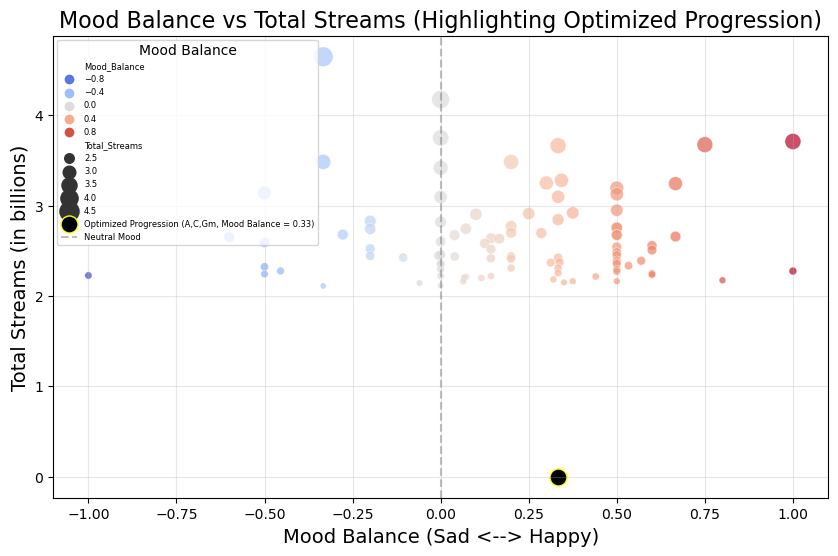

In [11]:
# define chord progression and mood balance 
optimized_progression = "A,C,Gm"  # For example, change this value to other chords (E, C, Dm)
optimized_balance = calculate_new_mood_balance(optimized_progression)
plt.figure(figsize=(10, 6))

# Plot all songs
sns.scatterplot(
    x='Mood_Balance', 
    y='Total_Streams', 
    data=cleaned_dataset, 
    hue='Mood_Balance', 
    palette='coolwarm', 
    size='Total_Streams', 
    sizes=(20, 200), 
    alpha=0.7
)

# Highlight the optimized progression
plt.scatter(
    optimized_balance, 
    0,  # Place it at y=0 since it doesn't have streams data
    color='black', 
    label=f'Optimized Progression ({optimized_progression}, Mood Balance = {optimized_balance:.2f})', 
    s=150, 
    edgecolor='yellow'
)

# Add vertical line for neutral mood
plt.axvline(0, color='gray', linestyle='--', alpha=0.5, label='Neutral Mood')

# Customize plot
plt.title('Mood Balance vs Total Streams (Highlighting Optimized Progression)', fontsize=16)
plt.xlabel('Mood Balance (Sad <--> Happy)', fontsize=14)
plt.ylabel('Total Streams (in billions)', fontsize=14)
plt.legend(title='Mood Balance', fontsize=6, loc='upper left')
plt.grid(alpha=0.3)
plt.show()

Woho! We have arrived! To conclude our analysis of how to actually write a bangin multi-billion dollar streamer we can summarize to the following insights:

1. Statistically the optimal amount of chords needed is 3
2. A,C,G are the most commonly used chords in hit songs. 
3. We have to adjust so we need to either replace one chord with two minor chords to achieve a score of -0.33 which is in the "mega streaming hit ballpark" or we do the other way around and keep two major chords and replace to one minor chord to achieve a score of 0.33. 

Now we just have to write the lyrics and melody... Well that's for another time, thanks for you time! 